# LOG6308 : Tp2 - Approche contenu

- Clément Bernard (2096223)
- Ghaith Dekhili (1858454)

## Importations 

In [1560]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import os
from sklearn.metrics.pairwise import cosine_similarity


from scipy.spatial import distance
import time
from sklearn import preprocessing
from numpy.linalg import multi_dot
from sklearn.model_selection import KFold

from nltk.stem import WordNetLemmatizer 
from nltk.tokenize import word_tokenize
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
nltk.download('punkt')
nltk.download('wordnet')

import time 
import torch
from sentence_transformers import SentenceTransformer, util
import seaborn as sns
import gensim 
from gensim.models import Word2Vec 
from nltk.tokenize import sent_tokenize, word_tokenize 

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/clementbernard/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/clementbernard/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [1561]:
DATA = os.path.join(os.getcwd(), 'data')
TABLE_PATH = os.path.join(DATA, 'citeseer.rtable')
ABSTRACT_PATH = os.path.join(DATA,'abstracts.csv')

## Data 


In [1562]:
# Matrice d'adjacence
m = pd.read_table(TABLE_PATH, sep=' ')
# Number of articles
N = m.shape[0]

# Question 1

## Data

In [1563]:
# The path where is the fold data
PATH_DATA = 'data'
# The items 
items = pd.read_csv(os.path.join(PATH_DATA, 'items.csv'), sep='|')
# User data 
u = pd.read_csv(os.path.join(PATH_DATA, 'u.csv'), sep='|')
# Votes of the user 
votes = pd.read_csv(os.path.join(PATH_DATA, 'votes.csv'), sep='|')

In [1564]:
items

,movie id,movie title,release date,video release date,IMDb URL,unknown,Action,Adventure,Animation,Children's,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1677,1678,Mat' i syn (1997),06-Feb-1998,NaN,http://us.imdb.com/M/title-exact?Mat%27+i+syn+...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1678,1679,B. Monkey (1998),06-Feb-1998,NaN,http://us.imdb.com/M/title-exact?B%2E+Monkey+(...,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
1679,1680,Sliding Doors (1998),01-Jan-1998,NaN,http://us.imdb.com/Title?Sliding+Doors+(1998),0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1680,1681,You So Crazy (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?You%20So%20Cr...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [1565]:
u

,id,age,gender,job,zip
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213
...,...,...,...,...,...
938,939,26,F,student,33319
939,940,32,M,administrator,02215
940,941,20,M,student,97229
941,942,48,F,librarian,78209


In [1566]:
votes

,user.id,item.id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596
...,...,...,...,...
99995,880,476,3,880175444
99996,716,204,5,879795543
99997,276,1090,1,874795795
99998,13,225,2,882399156


## Creation of sparse matrix : User-item matrix

In [1567]:
# The number of users 
N_USERS = u.shape[0] +1
# The number of items 
N_ITEMS = items.shape[0] +1 

In [1568]:
def create_sparse_matrix(votes) : 
    ''' Create a User-Items sparse matrix '''
    # Create NaN for each items and users 
    data = {i : [np.nan for j in range(N_USERS )] for i in range(N_ITEMS)}
    def to_convert(x, data) :
        data[x['item.id']][x['user.id']] = x['rating']
        return None 
    votes.apply(to_convert , axis = 1 , args = [data])
    return pd.DataFrame(data)

In [1569]:
user_item = create_sparse_matrix(votes)

In [1570]:
user_item

,0,1,2,3,4,5,6,7,8,9,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
940,NaN,NaN,NaN,NaN,2.0,NaN,NaN,4.0,5.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
941,NaN,5.0,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
942,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [1571]:
# We drop the first user who has no grades
user_item= user_item.iloc[1:,1:]

- On convertit les votes de la matrice user-items en des valeurs binaires

In [1572]:
def convert_to_binary(user_item):
    """
    returns a binary matrix by replacing votes equal or greater than 4 by 1 and 0 otherwise
    """
    user_item_binary = user_item.copy()
    # votes with 4 and 5 values become 1 and 0 otherwise 
    user_item_binary[user_item_binary < 4] = 0
    user_item_binary[user_item_binary >= 4] = 1
    return user_item_binary

- On compte le nombre total des aime/aime pas indépendemment des features

In [1573]:
def count_global_likes(user_item):
    """
    Counts global likes dislikes per item
    """
    #A df with number of likes and dislikes per item
    items_global_likes = pd.DataFrame(np.zeros((N_ITEMS-1, 2)), index = range(1,N_ITEMS))
    user_item_binary = convert_to_binary(user_item)
    for item in range(1,N_ITEMS):
        #Count number of 1(likes) and 0(dislikes) per item
        likes = user_item_binary[item].value_counts(normalize=False)
        #Fill with global number of likes and likes per item
        items_global_likes.loc[item,:] = likes
        #items_global_likes.loc[item,["dislikes","likes"]] = likes
    return user_item_binary, items_global_likes

- On convertit l'age en deux classes 'young' et 'old'

In [1574]:
def labelize_age(u):
    """
    labelize age based on users who are older than 25 are considered old
    rerturn a pandas Series with labelized ages
    """
    age_categorical = u[' age '].copy()
    age_categorical[u[' age '] > 25 ] = 'old'
    age_categorical[u[' age '] <= 25] = 'young'
    age_categorical = pd.DataFrame({'id ':[int(idx) for idx in u['id '].values],
                                    ' age ': age_categorical.values}, index = range(1,N_USERS))          
    return age_categorical

In [1575]:
def return_dict_feature_ids(u,column, age = False):
    """
    returns a dictionary of a feature categories with their associated users ids
    """
    feature_per_ids = {}
    #A df with a feature and its associated ids users, for we you labelize ages 
    if age:
        df_feature = labelize_age(u)
    else:
        df_feature = u[['id ', column]].copy() 
    #group by feature per user_ids
    feature_per_ids = {name: group['id '].values for name,group in df_feature.groupby([column])}
    return feature_per_ids

- On retourne le nombre des aime/aime-pas par feature

In [1576]:
def return_likes_dislikes_per_feature(u, user_item_binary, feature_per_ids):
    """
    returns likes dislikes matrices per feature
    """
    #initializations
    item_likes_per_feature = pd.DataFrame(np.nan, index = feature_per_ids.keys(), columns = range(1,N_ITEMS))
    item_dislikes_per_feature = pd.DataFrame(np.nan, index = feature_per_ids.keys(), columns = range(1,N_ITEMS))
    #Loop over features and associated users ids
    for job, ids in feature_per_ids.items():
        item_likes_per_feature.loc[job] = user_item_binary.loc[ids][user_item_binary.loc[ids]==1].count()
        item_dislikes_per_feature.loc[job] = user_item_binary.loc[ids][user_item_binary.loc[ids]==0].count()
    
    return item_likes_per_feature, item_dislikes_per_feature

- On calcule les odds et les probabilités globaux

In [1577]:
user_item_binary, items_global_likes = count_global_likes(user_item)
odds_likes = (items_global_likes.iloc[:,1]/items_global_likes.iloc[:,0])
proba_likes = odds_likes/(1+odds_likes)

- On calcule les odds des jobs

In [1578]:
#Returns a dictionary of jobs categories with their associated users ids
jobs_per_ids = return_dict_feature_ids(u, ' job ') 
#Return items likes and dislikes matrices per job
item_likes_per_job, item_dislikes_per_job = return_likes_dislikes_per_feature(u, user_item_binary, jobs_per_ids)
#calculate odds related to jobs
users_items_likes = (item_likes_per_job+1)/(((np.dot(pd.DataFrame(items_global_likes.iloc[:,1].replace(np.nan,0)+2),np.ones((1,item_likes_per_job.shape[0])))).T))
users_items_dislikes = (item_dislikes_per_job+1)/(((np.dot(pd.DataFrame(items_global_likes.iloc[:,0].replace(np.nan,0)+2),np.ones((1,item_likes_per_job.shape[0])))).T))
odds_jobs = pd.DataFrame(users_items_likes)/pd.DataFrame(users_items_dislikes)

- On calcule les odds des genders

In [1579]:
#Returns a dictionary of gender categories with their associated users ids
gender_per_ids = return_dict_feature_ids(u, ' gender ')
#Return items likes and dislikes matrices per gender
item_likes_per_gender, item_dislikes_per_gender = return_likes_dislikes_per_feature(u, user_item_binary, gender_per_ids)
#calculate odds related to gender
users_items_likes_gender = (item_likes_per_gender+1)/(((np.dot(pd.DataFrame(items_global_likes.iloc[:,1].replace(np.nan,0)),np.ones((1,item_likes_per_gender.shape[0])))).T)+2)
users_items_dislikes_gender = (item_dislikes_per_gender+1)/(((np.dot(pd.DataFrame(items_global_likes.iloc[:,0].replace(np.nan,0)),np.ones((1,item_dislikes_per_gender.shape[0])))).T)+2)
odds_gender = pd.DataFrame(users_items_likes_gender)/pd.DataFrame(users_items_dislikes_gender)

- On calcule les odds des cartégories d'âge

In [1580]:
#Returns a dictionary of age categories with their associated users ids
age_per_ids = return_dict_feature_ids(u, ' age ', age = True)
#Return items likes and dislikes matrices per age
item_likes_per_age, item_dislikes_per_age = return_likes_dislikes_per_feature(u, user_item_binary, age_per_ids)
#calculate odds related to age
users_items_likes_age = (item_likes_per_age + 1)/(((np.dot(pd.DataFrame(items_global_likes.iloc[:,1].replace(np.nan,0)),np.ones((1,item_likes_per_age.shape[0])))).T)+2)
users_items_dislikes_age = (item_dislikes_per_age + 1)/(((np.dot(pd.DataFrame(items_global_likes.iloc[:,0].replace(np.nan,0)),np.ones((1,item_dislikes_per_age.shape[0])))).T)+2)
odds_age = pd.DataFrame(users_items_likes_age)/pd.DataFrame(users_items_dislikes_age)

## Recommandation  de 10 films sur la base de trois catégories

In [1581]:
def return_recommendations(job, gender, age, odds_likes, odds_jobs, odds_gender, odds_age):
    """
    return first 10 items recommendations based on input job, gender,age
    """
    odds = odds_likes*(odds_jobs.T)[job]*(odds_gender.T)[gender]*((odds_age.T))[age]
    return  (odds/(1+odds)).sort_values(ascending=False)[0:10]

- Un example de recommandation des fils pour une femme ingénieure jeune

In [1582]:
return_recommendations('engineer', 'F', 'young', odds_likes = odds_likes, odds_jobs = odds_jobs, odds_gender = odds_gender, odds_age = odds_age)

483    0.967840
480    0.950883
115    0.928483
83     0.927111
107    0.927056
478    0.913225
114    0.911541
302    0.911324
918    0.908075
487    0.904690
dtype: float64

## Calcul des votes et du RMSE moyen 

In [1583]:
a_c = labelize_age(u)
s = pd.DataFrame(u[' gender '].values, index = range(1,N_USERS), columns = [' gender '])
j = pd.DataFrame(u[' job '].values, index = range(1,N_USERS), columns = [' job '])
new_u = pd.concat([a_c , s , j], axis = 1)

In [1584]:
def calculate_votes(user_item = user_item, new_u = new_u, odds_jobs = odds_jobs, odds_gender = odds_gender, odds_age = odds_age):
    """
    calculates votes based on probabilities
    """
    #A df which contains votes
    all_votes_predictions = pd.DataFrame(np.zeros((user_item.shape[0],user_item.shape[1])), index = range(1,N_USERS) ,columns = range(1,N_ITEMS))
    #A new df with age, gender and job in the needed labelization 
    s = pd.DataFrame(u[' gender '].values, index = range(1,N_USERS), columns = [' gender '])
    j = pd.DataFrame(u[' job '].values, index = range(1,N_USERS), columns = [' job '])
    a_c = labelize_age(u)
    new_u = pd.concat([a_c , s , j], axis = 1)
    #Calculate likes and dislikes averages
    likes_avgs = user_item[user_item >= 4].mean()
    dislikes_avgs = user_item[user_item < 4].mean()
    #Loop over the new df to calculate votes
    for index, row in new_u.iterrows():
        #Calculate odd by multiplying odds matrices
        all_odds = (odds_jobs.T[row[' job ']])*(odds_gender.T[row[' gender ']])*(odds_age.T[row[' age ']])
        #Calculates probabilities based on odds
        all_probs = all_odds/(1+all_odds)
        #Calculte votes per user
        user_votes = (all_probs*likes_avgs + (1-all_probs)*dislikes_avgs)
        #Fill in the df votes
        all_votes_predictions.loc[index,:] = user_votes
    
    return all_votes_predictions

In [1585]:
def compute_rmse(prediction , user_item = user_item ) : 
    ''' Return the RMSE between the prediction and the user-item matrix '''
    # Index where the user_item is not null
    indexes_not_nan = user_item.notnull()
    rmse = np.sqrt(((prediction[indexes_not_nan] - user_item[indexes_not_nan])**2).mean())
    return rmse

- On convertit les probabilités en des votes

In [1586]:
all_votes_predictions = calculate_votes(user_item, new_u, odds_jobs, odds_gender, odds_age)

- On calcule le RMSE moyen

In [1587]:
compute_rmse(all_votes_predictions, user_item).mean()

1.021163785917258

# Question 2

- Tout d'abord, nous utilisons une fonction qui permet d'obtenir les N recommandations à partir d'une matrice de similarité. 
Cela sera utilisé pour chacune des fonctions après.

In [1588]:
def get_recommendation_sim(df_sim , m = m , N=10) :
    ''' Return the top N recommendation using the similarity matrix '''
    # Get the indexes that maximises the cosine similarity
    idx = (-df_sim.values).argsort()
    # Keep the N max
    idx = idx[:,:N]
    # Convert the indexes into article indexes
    article_idx = np.zeros(idx.shape)
    for i,index in enumerate(idx) : 
        for j,index_ in enumerate(index) : 
            article_idx[i,j] = m.index[index_]
    return pd.DataFrame(article_idx, index = m.index)

- Nous appliquons l'algorithme PageRank. On utilise la version matricielle 
- Pour eviter de diviser par 0, on remplit la diagonale à 1
- Ensuite, pour respecter le format de l'algorithme, on utilise la transposée de la matrice d'adjacence.


In [1589]:
def page_rank(m , d = 0.85, epsilon = 1e-5, max_iter = 10000) : 
    ''' Compute the PageRank score '''
    m_bis = m.T.copy()
    # Number of articles 
    N = m.shape[0]
    # PageRank values
    r = np.ones((1,N))
    # Initialise the condition 
    new_r = r + 10
    # Iteration 
    iteration = 0
    # Fill the diagonal to be 1, to avoid the division by 0 
    np.fill_diagonal(m_bis.values,1)
    # Condition : if the mean of difference is greater than epsilon
    condition = abs(r - new_r).mean() > epsilon 
    
    while condition and iteration < max_iter     : 
        # Get the number of output links 
        s = m_bis.sum(axis=0).values.reshape(-1,1)
        # Get the new PageRank vector
        new_r = (1-d)/N +  d * m_bis @ (r.T / s)                
        # Convert into numpy 
        new_r = new_r.values.T
        # Update the condition 
        condition = abs(r - new_r).mean() > epsilon
        r = new_r
        iteration+=1
        
    return pd.DataFrame(r.reshape(-1,), index = m.index, columns=['PageRank'])

- On utilise les hyperparamètres suivant : 
       - d = 0.85
       - epsilon = 1e-5 
       - Itération maximale : 1000

In [1590]:
r = page_rank(m, d= 0.85, epsilon = 1e-5, max_iter = 1000)

In [1591]:
r

,PageRank
100299,0.000192
100967,0.000243
10151,0.000244
101705,0.000239
101863,0.000267
...,...
97863,0.000150
98185,0.000199
99113,0.000175
9947,0.000230


- Recommendation : prendre les articles maximum de PageRank multiplié par la matrice d'adjacence 

In [1592]:
def get_recommendation_page_rank(index = None , r = r, m=m,N= 10 ): 
    ''' Return recommendations for the index article from PageRank score '''
    # Get the element wise product between the PageRank and adjacent matrix
    df_sim = pd.DataFrame(pd.concat([r.T]*m.shape[0], axis = 0).values * m.values)
    # Get the recommendation 
    recommendation = get_recommendation_sim(df_sim , m = m , N=N)
    if index is None : 
        return recommendation
    return recommendation[recommendation.index == index]

In [1593]:
get_recommendation_page_rank(422908, N = 10)

,0,1,2,3,4,5,6,7,8,9
422908,311874.0,396568.0,522428.0,19422.0,17094.0,155792.0,64835.0,315693.0,110303.0,241538.0


##  Variante : etendre le sous-ensemble S aux références de références

In [1594]:
m_ = m.values @ m.values + m.values

- On met a 1 les référencements qui sont multiples ou qui ont un chemin supérieur à 1 

In [1595]:
m_[m_ >1] = 1

In [1596]:
new_m = m.copy()
new_m[:] = m_
new_m

,100299,100967,10151,101705,101863,102458,102886,102966,10302,103700,...,96767,97060,97150,9721,97410,97863,98185,99113,9947,9993
100299,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
100967,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10151,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
101705,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
101863,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97863,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
98185,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
99113,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9947,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


- On applique PageRank a ce nouvel espace 

In [1597]:
new_r = page_rank(new_m, d= 0.85, epsilon = 1e-5, max_iter = 1000)

In [1598]:
new_r

,PageRank
100299,0.000192
100967,0.000177
10151,0.000211
101705,0.000239
101863,0.000162
...,...
97863,0.000140
98185,0.000145
99113,0.000157
9947,0.000184


- On recommande ensuite 

In [1599]:
# Methode Page Rank ++ 
get_recommendation_page_rank(422908,r = new_r, m = new_m)

,0,1,2,3,4,5,6,7,8,9
422908,311874.0,396568.0,389559.0,522428.0,19422.0,241538.0,225173.0,425638.0,206738.0,315693.0


In [1600]:
# Methode Page Rank classique 
get_recommendation_page_rank(422908)

,0,1,2,3,4,5,6,7,8,9
422908,311874.0,396568.0,522428.0,19422.0,17094.0,155792.0,64835.0,315693.0,110303.0,241538.0


- L'idée de l'extension du sous-ensemble est de considérer les articles qui sont des références aux références.
- Pour cela, on considère $m^2$. Chacun des valeurs de cette matrice va donner le nombre de lien directe ou indirecte (avec un référencement de référencement). On met ensuite les valeurs de cette matrice a 1 et on utilise PageRank classiquement
- Les deux méthodes recommandent les 2 mêmes articles en premier, et ensuite le 3eme article diffère. Cela signifie que certains articles ont un PageRank plus   

# Question 3

- On considère pour cette question qu'un utilisateur est représenté par son vecteur dans la matrice d'adjacence
- On calcule ensuite la distance cosinus pour chaque utilisateur 
- Remarque : la première recommendation sera forcément l'utilisateur lui-même 

In [1601]:
def get_recommendation_vector(index = None , m = m , N = 10) : 
    ''' Return the recommendation with vector space of adjacence matrix '''
    df_sim = pd.DataFrame(cosine_similarity(m,m), index = m.index, columns = m.columns)
    # Get the recommendation 
    recommendation = get_recommendation_sim(df_sim , m = m , N=N)
    if index is None : 
        return recommendation
    return recommendation[recommendation.index == index]

- 10 meilleures recommendations de 422908

In [1602]:
get_recommendation_vector(422908, N = 10)

,0,1,2,3,4,5,6,7,8,9
422908,422908.0,96767.0,70445.0,149673.0,466838.0,155792.0,53632.0,497542.0,3175.0,17507.0


# Question 4

In [1603]:
abstract = pd.read_csv(ABSTRACT_PATH)

In [1604]:
abstract

,Unnamed: 0,Id,Titre,Auteurs,Description
0,1,124,Hybrid Automata: An Algorithmic Approach to th...,Costas Courcoubetis; Pei-hsin Ho; Rajeev Alur;...,We introduce the framework of hybrid automata ...
1,2,496,Representing Action: Indeterminacy and Ramific...,Enrico Giunchiglia; G. Neelakantan Kartha; Vla...,We define and study a high-level language for ...
2,3,712,A Decision Procedure for a Temporal Belief Logic,Michael Fisher; Michael Wooldridge;,. This paper presents a temporal belief logic ...
3,4,1186,A Comparative Evaluation of Sequential Feature...,David W. Aha; Richard L. Bankert;,Several recent machine learning publications d...
4,5,1347,Extending Promela and Spin for Real Time,Costas Courcoubetis; Stavros Tripakis;,The efficient representation and manipulation ...
...,...,...,...,...,...
1085,1086,548670,Null,NaN,NaN
1086,1087,549091,Null,NaN,NaN
1087,1088,561317,Null,NaN,NaN
1088,1089,570764,Null,NaN,NaN


- On ne considère que les descriptions 
- On utilise le TFidfVectorizer de sklearn pour vectoriser les descriptions de l'abstract

In [1605]:
def get_term_document_matrix(corpus = abstract['Description'] ) : 
    ''' Return the term document matrix with TF-IDF '''
    # Number of documents 
    n_document = abstract.shape[0]
    # Vectorizer : the tf-idf vectorizer that does the Tokenisation and TF-IDF transformation
    vectorizer = TfidfVectorizer(strip_accents = 'unicode')
    # Get the corpus to apply the TF-IDF
    corpus = corpus.fillna(' ').values
    # Do the Tokenisation and TF-IDF
    tf_idf = vectorizer.fit_transform(corpus)
    # Vocabulary
    vocab = list(vectorizer.vocabulary_.keys())
    # Size of the vocabulary
    n_vocab = tf_idf.shape[1]
    # Term-document matrix 
    term_document = pd.DataFrame(tf_idf.todense().T, index = vocab, columns = abstract['Id'].values)
 
    return term_document

In [1606]:
term_document = get_term_document_matrix()

- On obtient une matrice terme-document : en abscisse il y a les différents mots du corpus, et en ordonnée les différents documents (ici les articles)
- Les valeurs de la matrice correspondent à la TF-IDF pour un mot et un article donné

In [1607]:
term_document

,124,496,712,1186,1347,1948,2104,2111,2490,3156,...,543817,545708,547939,548310,548620,548670,549091,561317,570764,573595
we,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
introduce,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
the,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
framework,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
of,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
byproduct,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
lar90,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
lt88,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
glz89,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [1608]:
def get_recommendation_term_document(index = None , term_document = term_document, m = m, N=10) :
    ''' Return the top N recommendation using the cosine similarity '''
    # Get the similarity for each user 
    df_sim = pd.DataFrame(cosine_similarity(term_document.T,term_document.T), index = m.index, columns = m.index)
    recommendation = get_recommendation_sim(df_sim , m = m , N=N)
    if index is None : 
        return recommendation
    return recommendation[recommendation.index == index]
    

- 10 recommendations de l'article 422908

In [1609]:
get_recommendation_term_document(422908, N = 10)

,0,1,2,3,4,5,6,7,8,9
422908,422908.0,430308.0,484335.0,340126.0,396568.0,19249.0,22904.0,164633.0,3950.0,230897.0


# Question 5

- Tout d'abord, nous utilisons une fonction qui convertit les recommendations pour avoir le format d'une matrice d'adjacence, avec des 1 pour la recommandation 

In [1610]:
def convert_recommendation_matrix(recommendations, m=m) : 
    ''' Convert the Top N recommendations to be represented as 1 in a 1090x1090 matrix '''
    # A 1090x1090 matrix with 1 when there is a recommendation
    m_rec = pd.DataFrame(np.zeros((m.shape[0], m.shape[0])), columns = list(m.index), index = list(m.index))
    
    for (index, row) in recommendations.iterrows() : 
        for k in row : 
            m_rec.loc[index,k] = 1 
    return m_rec

- On créer une matrice avec les références et les référencés pour utilisons une cross-validation dessus 

In [1611]:
m_base = pd.read_table(TABLE_PATH, sep=' ')

def return_df_citations(m_base = m_base):  
    """
    returns a 2 columns df with refree/referenced papers
    """
    citations = []
    
    for i, (index, row) in enumerate(m_base.iterrows()):
        indexes = row[row ==1].index
        for k in indexes:
            if index != int(k) : 
                citations.append([index,k])
            
    return pd.DataFrame(citations, columns = ['referee','referenced'])

In [1612]:
df_citations = return_df_citations(m_base = m_base)

In [1613]:
df_citations

,referee,referenced
0,100299,170577
1,100299,527057
2,100967,173238
3,100967,185918
4,100967,275211
...,...,...
2816,9993,245669
2817,9993,248598
2818,9993,311874
2819,9993,353044


- Fonction de cross-validation : on créer une liste de matrice d'adjacence (training et validation) 

In [1614]:
def k_fold(df_citations = df_citations, m = m_base  , N = 10) : 
    ''' Return the adjacent matrices for training and testing set, for N folds '''
    training = []
    testing = []
    np.fill_diagonal(m.values, 0)
    
    kf = KFold(n_splits = N , random_state = None, shuffle = True)
    
    for train_index, test_index in kf.split(df_citations) :
        
        m_copy = m.copy()
        m_test = m.copy()
                
        m_test.iloc[:,:] = 0
        
        test_indexes_citations = df_citations.iloc[test_index]
        for j,k in zip(test_indexes_citations['referee'].values, test_indexes_citations['referenced'].values) :            
            
            m_copy.loc[j,k] = 0
            m_test.loc[j,k] = 1
            
            
        m_copy.columns = m.index
        m_test.columns = m.index
        
        training.append(m_copy)
        testing.append(m_test)
        
    return training, testing 

# Fonctions de recommandations 

- Pour toutes les fonctions de recommandations, on utilise le format souhaité. 
- Les arguments sont les suivant : matrice_adjacence_entrainement, *args, **kwargs

## Similarité vector space  

- Recommendation pour la methode de la question 3 : matrice d adjacence comme espace vectoriel 

In [1615]:
def fn_recommendations_vector(matrice_adjacence_entrainement, *args, **kwargs) : 
    ''' Get the Top-20 recommendations : Similarity with adjacence matrix '''
    recommendations = get_recommendation_vector(index = None , m = matrice_adjacence_entrainement , N = 20)
    # Convert to be of the size 1090 x 1090 with 1 when there is a recommendation 
    m_rec = convert_recommendation_matrix(recommendations)
    return m_rec

## Similarité PageRank standard

- Recommandation avec PageRank

In [1616]:
def fn_recommendations_pagerank(matrice_adjacence_entrainement, *args, **kwargs) : 
    ''' Get the Top-20 recommendations : PageRank '''
    # Compute PageRank
    r = page_rank(matrice_adjacence_entrainement, d= 0.85, epsilon = 1e-5, max_iter = 1000)
    # Get the recommendations for every article
    recommendations = get_recommendation_page_rank(index = None , r = r, m=matrice_adjacence_entrainement,N= 20 )   
    # Convert to be of the size 1090 x 1090 with 1 when there is a recommendation 
    m_rec = convert_recommendation_matrix(recommendations)
    return m_rec

## Similarité PageRank étendu

- Recommandation avec PageRank++ : sous-ensemble etendu 

In [1692]:
def fn_recommendations_pagerank_(matrice_adjacence_entrainement, *args, **kwargs) : 
    ''' Get the Top-20 recommendations : PageRank++ '''
    # Extend the neighborhood 
    m_ = matrice_adjacence_entrainement.values @ matrice_adjacence_entrainement.values +\
    matrice_adjacence_entrainement.values
    new_m = matrice_adjacence_entrainement.copy()
    new_m[:] = m_
    new_m[new_m>1] = 1 
    np.fill_diagonal(new_m.values,0)
    r = page_rank(new_m, d= 0.85, epsilon = 1e-5, max_iter = 1000)
    # Get the recommendations for every article
    recommendations = get_recommendation_page_rank(index = None,r = r, m = matrice_adjacence_entrainement, N =20)
    # Convert to be of the size 1090 x 1090 with 1 when there is a recommendation 
    m_rec = convert_recommendation_matrix(recommendations)
    return m_rec

## Similarité TF-IDF

- Recommandation avec TF-IDF

In [1618]:
def fn_recommendations_tfidf(matrice_adjacence_entrainement, *args, **kwargs) : 
    ''' Do the recommendations with the tf-idf method '''
    term_document = args[0][0]['term_document']
    
    recommendations = get_recommendation_term_document(index = None , term_document = term_document,\
                                                       m = matrice_adjacence_entrainement, N=20) 
    m_rec = convert_recommendation_matrix(recommendations)
    
    return m_rec

## Similarité Word2Vec

- Recommendation avec Word2Vec : on utilise un embedding Word2Vec au lieu de TF-IDF pour les descriptions.  
- Chacun des mots est représenté avec un embedding Word2Vec. 
- Chacune des phrases est représentée par la moyenne des représentations des mots 
- Cependant, prendre la moyenne va retirer le contexte et certainement faire une représentation assez mauvaise

In [1619]:
def model_word2vec(abstract = abstract) : 
    ''' Return a word2vec model '''
    data = abstract['Description'].fillna(' ').values
    # Tokenize the data 
    data_tok = []
    for sentence in data : 
        data_tok.append(word_tokenize(sentence))
    # Create the model 
    model = gensim.models.Word2Vec(data_tok, min_count = 1,  
                              size = 1000, window = 5)
    model.train(data_tok , total_examples=len(abstract), epochs=100)
    return model

In [1620]:
def embed_sentences(model, sentences) : 
    ''' Embed sentences '''
    # Create a tokenization 
    data_tok = []
    for sentence in sentences : 
        temp = []
        words = word_tokenize(sentence)
        for word in words : 
            if word in model.wv.vocab : 
                temp.append(word)
        data_tok.append(temp)
    
    token_dim = model.wv[model.wv.vocab].shape[1]
    embedded = np.zeros((len(sentences), token_dim))
    for i,sentence in enumerate(data_tok) : 
        try : 
            embed = model.wv[sentence].sum(axis = 0)
        except ValueError : 
            pass
        embedded[i,:] = embed
    
    return embedded

In [1621]:
def get_embedding(abstract = abstract, m = m ) : 
    ''' Return the embedding of the abstract using Word2Vec '''
    model = model_word2vec(abstract)
    embedding = embed_sentences(model, abstract['Description'].fillna(' ').values)
    return embedding

In [1622]:
def get_recommendation_word2vec(embedding, N = 20 , m = m ) : 
    ''' Return the recommendation for the word2vec embedding '''
    df_sim = cosine_similarity(embedding, embedding)
    # Disallow self recommendations 
    np.fill_diagonal(df_sim, 0)
    df_sim = pd.DataFrame(df_sim, index =  m.index, columns = m.index)
    recommendations = get_recommendation_sim(df_sim, N = N , m = m )
    return recommendations

- Fonction final Word2Vec

In [1623]:
def fn_recommendations_word2vec(matrice_adjacence_entrainement, *args, **kwargs) : 
    ''' Do the recommendations with the Word2Vec vectorisation of the abstract '''
    embedding = args[0][0]['embedding']
    recommendations = get_recommendation_word2vec(embedding, N = 20, m = matrice_adjacence_entrainement)
    return recommendations

## Similarité titre + PageRank++ 

- Recommandation avec augmentation du voisinage avec similitudes des titres 
- On calcul le TF-IDF, puis la similitude de chaque document avec les autres grâce à la représentation TF-IDF.
- Ensuite, on rajoute à la matrice d'adjacence les M documents les plus similaires (M est un hyperparamètre)
- Puis, on utilise la méthode PageRank avec cette nouvelle matrice d'adjacence

In [1624]:
def get_term_document_titles(abstract = abstract) : 
    ''' Return the sim matrix with the titles '''
    titles = abstract['Titre']
    term_document_titles = get_term_document_matrix(corpus =titles  ) 
    return term_document_titles

In [1625]:
def fn_recommendations_titles(matrice_adjacence_entrainement, *args, **kwargs) : 
    ''' Return recommendation with titles '''
    term_document_titles = args[0][0]['term_document']
    
    recommendations = get_recommendation_term_document(index = None , term_document = term_document_titles,\
                                                       m = matrice_adjacence_entrainement, N=20) 
    m_rec = convert_recommendation_matrix(recommendations)
    
    return m_rec
    

In [1626]:
def add_negihborhood(m, indexes) : 
    ''' Add 1 to all the indexes of the matrix '''
    new_m = m.copy()
    for i, index in enumerate(indexes) : 
        for j in index :
            new_m.iloc[i,j] = 1
    return new_m

In [1627]:
def fn_recommendations_pagerank_titles(matrice_adjacence_entrainement, *args, **kwargs) : 
    ''' Return recommendations with PageRank extended with the titles similarity '''
    term_document_titles = args[0][0]['term_document']
    
    M = args[0][0]['title_neigh']
    
    df_sim = pd.DataFrame(cosine_similarity(term_document_titles.T,term_document_titles.T),\
                          index = matrice_adjacence_entrainement.index, columns = matrice_adjacence_entrainement.index)
    np.fill_diagonal(df_sim.values, 0)
    
    indexes = (-df_sim.values).argsort()[:,:M]
    
    new_m = add_negihborhood(matrice_adjacence_entrainement, indexes)
    
    return fn_recommendations_pagerank(new_m)
    

## Similarité PageRank extended

- Recommandation avec extension de la matrice d'adjance (PageRank extended)
- On considère les références des références, les référents des référents et les référés
- Si on note m la matrice d'adjance, cela correspond à : $m^2 + m.T + (m.T)^2$
- On applique ensuite PageRank

In [1628]:
def fn_recommendations_page_rank_extended(matrice_adjacence_entrainement, *args, **kwargs) : 
    ''' Return recommendations with PageRank extended '''
    
    new_m = matrice_adjacence_entrainement.copy()
    
    m_ = new_m.values @ new_m.values + new_m.values.T + (new_m.values.T @ new_m.values.T) 
    
    new_m = matrice_adjacence_entrainement.copy()
    
    new_m[:] = m_
    
    new_m[new_m>1] = 1 
    
    np.fill_diagonal(new_m.values,0)
    
    r = page_rank(new_m, d= 0.85, epsilon = 1e-5, max_iter = 1000)
    
    recommendations = get_recommendation_page_rank(index = None,r = r, m = new_m, N =20)

    m_rec = convert_recommendation_matrix(recommendations)
    return m_rec
    

## Similarité vector space étendu avec auteurs et titres 

- Recommandation avec une moyenne pondérée des matrices de similarité TF-IDF titres, auteurs et matrice d'adjacence
- On prend 0.1 fois la matrice de similarité des titres (avec TF-IDF)
- On prend 0.1 fois la matrice de similarité des auteurs (avec TF-IDF)
- On prend 0.8 fois la matrice de similarité cosinus de la matrice d'adjacence

In [1629]:
def get_tf_idf_titles_authors(abstract = abstract) :
    ''' Return the tf-idf matrix for Authors and titles '''
    authors = get_term_document_matrix(corpus = abstract['Auteurs'] )
    titles = get_term_document_matrix(corpus = abstract['Titre'] )
    return {'term_document_title' : titles, 'term_docment_authors' : authors}

In [1630]:
def fn_recommendations_vector_authors_titles(matrice_adjacence_entrainement, *args, **kwargs) : 
    ''' Return recommendations with Vector Space method, with extension of neighborhood with titles and authors '''
    term_document_titles = args[0][0]['term_document_title']
    term_document_authors = args[0][0]['term_docment_authors']
    
    M = 25
    N_COMPONENT = 10
    # Get similarity matrix for titles
    df_sim_titles = pd.DataFrame(cosine_similarity(term_document_titles.T,term_document_titles.T),\
                          index = matrice_adjacence_entrainement.index, columns = matrice_adjacence_entrainement.index)
    # Get similarity matrix for authors
    df_sim_authors = pd.DataFrame(cosine_similarity(term_document_authors.T,term_document_authors.T),\
                          index = matrice_adjacence_entrainement.index, columns = matrice_adjacence_entrainement.index)
    # Get similarity matrix for adjacent matrix 
    df_sim_vector = pd.DataFrame(cosine_similarity(matrice_adjacence_entrainement.T,matrice_adjacence_entrainement.T),\
                          index = matrice_adjacence_entrainement.index, columns = matrice_adjacence_entrainement.index)
    # Average the three matrix with the following weights 
    weights = [0.1, 0.1,0.8]
    df_sim = (weights[0] * df_sim_titles + weights[1] * df_sim_authors + weights[2] * df_sim_vector)/3
    recommendations = get_recommendation_sim(df_sim , m = m , N=20) 
    # Convert to be of the size 1090 x 1090 with 1 when there is a recommendation 
    m_rec = convert_recommendation_matrix(recommendations)

    return m_rec

# Use of SBERT

- Function for SBERT

In [1631]:
def get_sbert_embeds(column, column2 = None, concat = False):
    """
    Build contextualized embeddings using sbert
    """
    #Call the model using sentence_transformers library
    model = SentenceTransformer('paraphrase-distilroberta-base-v1')
    #Buil embeddings depending on given features (title, description or both)
    embeds = []
    if concat:
        sentences =  abstract[column] + '. ' + abstract[column2]
    else:
        sentences = abstract[column].values
    for s in sentences:
        if s is not np.nan:
            emb1 = model.encode(s, convert_to_tensor=True, show_progress_bar=False)
        else:
            emb1 = torch.zeros([768])
        embeds.append(emb1)
    embeds = torch.stack(embeds,dim=0)
    return embeds

In [1632]:
def get_sbert_similarities(columns):
    """
    returns a df with similarities computed depending on the abstract columns
    """  
    #Compute embeddings using sbert pre-trained model
    sbert_embeds = get_sbert_embeds(columns['column'],columns['column2'], columns['concat'])
    #Compute similarities using obtained embedings
    cosine_scores = util.pytorch_cos_sim(sbert_embeds, sbert_embeds)
    #Get a df with similarities between pairs of documents 
    df_similarities = pd.DataFrame(cosine_scores.tolist(), index = abstract['Id'].values, columns = abstract['Id'].values)
    return df_similarities

In [1633]:
def get_recommendations_sbert_embeds(matrice_adjacence_entrainement, df_sim, N=20) :
    ''' Return the top N recommendation using the sbert similarities '''
    # Get the indexes that maximises the similarity
    idx = (-df_sim.values).argsort()
    # Keep the N max
    idx = idx[:,:N]
    # Convert the indexes into article indexes
    article_idx = np.zeros(idx.shape)
    for i,index in enumerate(idx) : 
        for j,index_ in enumerate(index) : 
            article_idx[i,j] = df_sim.columns[index_]
    return pd.DataFrame(article_idx, index = df_sim.columns)

In [1652]:
def fn_recommendations_sbert_embeds(matrice_adjacence_entrainement, *args, **kwargs): 
    ''' Return recommendations with the sbert method '''
    df_sim = args[0][0]['df_sim']
    recommendations = get_recommendations_sbert_embeds(matrice_adjacence_entrainement, df_sim, args[0][0]['N']) 
    m_rec = convert_recommendation_matrix(recommendations)                                                    
    return m_rec

## Combinaison de SBERT (titres + descriptions) et PageRank

In [1636]:
def fn_recommendations_pagerank_titles(matrice_adjacence_entrainement, *args, **kwargs) : 
    ''' Return recommendations with PageRank extended with the titles similarity '''
    term_document_titles = args[0][0]['term_document']
    
    M = args[0][0]['title_neigh']
    
    df_sim = pd.DataFrame(cosine_similarity(term_document_titles.T,term_document_titles.T),\
                          index = matrice_adjacence_entrainement.index, columns = matrice_adjacence_entrainement.index)
    np.fill_diagonal(df_sim.values, 0)
    
    indexes = (-df_sim.values).argsort()[:,:M]
    
    new_m = add_negihborhood(matrice_adjacence_entrainement, indexes)
    
    return fn_recommendations_pagerank(new_m)

#  Calcul de recall

- Fonctions de calcul de rappel 

In [1637]:
def fn_taux_rappel(matrice_adjacence_test, recommandations) : 
    ''' Return the recall ratio '''
    return ((matrice_adjacence_test+recommandations)==2).sum().sum()/matrice_adjacence_test.sum().sum()

In [1647]:
def get_recall(fn_recommandations, *args, **kwargs ) : 
    ''' Get the recall averaged 5 times '''
    recall = []
    for i in range(5) : 
        training_adjacences , testing_adjacences = k_fold(m = m_base)
        recall_val = []
        for matrice_train, matrice_test in zip(training_adjacences, testing_adjacences) : 
            recommandations = fn_recommandations(matrice_train, args, kwargs)
            current_recall = fn_taux_rappel(matrice_test, recommandations)
            recall_val.append(current_recall)
        recall.append(np.mean(recall_val))
    return np.mean(recall)

# Résultats de Recall

- Les différents résultats des méthodes précédentes

In [1639]:
# Variable to keep the results 
score_models = {}

## Recall pour similarité Vector Space


In [1665]:
score_models['Vector Space'] = get_recall(fn_recommendations_vector)

In [1666]:
score_models['Vector Space']

0.22261083126581963

## Recall pour PageRank standard

In [1667]:
score_models['PageRank'] = get_recall(fn_recommendations_pagerank)

In [1668]:
score_models['PageRank']

0.017865824624714935

## Recall pour PageRank étendu

In [1693]:
score_models['PageRank+'] = get_recall(fn_recommendations_pagerank_)

In [1694]:
score_models['PageRank+']

0.018151016214319728

## Recall pour TF-IDF

In [1671]:
args = {'term_document' : get_term_document_matrix()}

In [1672]:
score_models['TF-IDF'] = get_recall(fn_recommendations_tfidf, args)

In [1673]:
score_models['TF-IDF']

0.022688519660175925

# Recall pour Word2Vec

In [1674]:
args = {'embedding' : get_embedding()}

In [1675]:
score_models['Word2Vec'] =  get_recall(fn_recommendations_word2vec, args)

In [1676]:
score_models['Word2Vec']

0.0

# Recall pour TF-IDF sur les titres

In [1677]:
args = {'term_document' : get_term_document_titles()}

In [1678]:
score_models['TF-IDF titles'] = get_recall(fn_recommendations_titles, args)

In [1679]:
score_models['TF-IDF titles']

0.01630604215221913

# Recall titre + PageRank++ 

In [1680]:
args = {'term_document' : get_term_document_titles(),
       'title_neigh' : 100}

In [1681]:
score_models['PageRank + Titles'] = get_recall(fn_recommendations_pagerank_titles, args)

In [1682]:
score_models['PageRank + Titles']

0.020346590481918652

# Recall vector space etendu avec Auteurs et Titres 

In [1683]:
args = get_tf_idf_titles_authors()

In [1684]:
score_models['Vector Space + Titles + Authors'] = get_recall(fn_recommendations_vector_authors_titles, args)

In [1685]:
score_models['Vector Space + Titles + Authors']

0.2566463674410445

# Recall PageRank extended 

In [1686]:
score_models['PageRank extended'] = get_recall(fn_recommendations_page_rank_extended)

In [1687]:
score_models['PageRank extended']

0.3458993058166053

## Recall pour SBERT avec les titres 

In [1641]:
columns = {'column' : 'Titre', 'column2': None, 'concat' : None, 'N':20}
df_sim = get_sbert_similarities(columns)
args = {'df_sim' : df_sim, 'N':20, 'column':columns, 'sbert':True}

  0%|          | 0.00/306M [00:00<?, ?B/s]

In [1653]:
score_models['SBERT_titles'] = get_recall(fn_recommendations_sbert_embeds, args)

In [1654]:
score_models['SBERT_titles']

0.17370398215673008

## Recall pour SBERT avec les descriptions 

In [1656]:
columns = {'column' : 'Description', 'column2': None, 'concat' : None, 'N':20}
df_sim = get_sbert_similarities(columns)
args = {'df_sim' : df_sim, 'N':20, 'column':columns, 'sbert':True}

In [1657]:
score_models['SBERT_Description'] = get_recall(fn_recommendations_sbert_embeds, args)

In [1658]:
score_models['SBERT_Description']

0.2155208881537729

## Recall pour SBERT en combinant les titres + les descriptions 

In [1659]:
columns = {'column' : 'Titre', 'column2': 'Description', 'concat' : True, 'N':20}
df_sim = get_sbert_similarities(columns)
args = {'df_sim' : df_sim, 'N':20, 'column':columns, 'sbert':True}

In [1660]:
score_models['SBERT_Titles_Description'] = get_recall(fn_recommendations_sbert_embeds, args)

In [1661]:
score_models['SBERT_Titles_Description']

0.23466731824674839

# Summary 

In [1695]:
def get_summary(score_models,order = True) : 
    ''' Return a DataFrame with the summary of the results '''
    if order : 
        score_models = {key : -100 * value for key,value in zip(list(score_models.keys()), list(score_models.values()))}
        score_models = {key: value for key, value in sorted(score_models.items(), key=lambda item: item[1])}
        score_models = {key : -value for key,value in zip(list(score_models.keys()), list(score_models.values()))}
    to_df = {'Algorithm' : list(score_models.keys()) , 'Recall' : list(score_models.values())}
    
    return pd.DataFrame(to_df)

In [1696]:
df = get_summary(score_models, order = True)

In [1697]:
df

,Algorithm,Recall
0,PageRank extended,34.589931
1,Vector Space + Titles + Authors,25.664637
2,SBERT_Titles_Description,23.466732
3,Vector Space,22.261083
4,SBERT_Description,21.552089
5,SBERT_titles,17.370398
6,TF-IDF,2.268852
7,PageRank + Titles,2.034659
8,PageRank+,1.815102
9,PageRank,1.786582


[Text(0, 0, 'PageRank extended'),
 Text(1, 0, 'Vector Space + Titles + Authors'),
 Text(2, 0, 'SBERT_Titles_Description'),
 Text(3, 0, 'Vector Space'),
 Text(4, 0, 'SBERT_Description'),
 Text(5, 0, 'SBERT_titles'),
 Text(6, 0, 'TF-IDF'),
 Text(7, 0, 'PageRank + Titles'),
 Text(8, 0, 'PageRank+'),
 Text(9, 0, 'PageRank'),
 Text(10, 0, 'TF-IDF titles'),
 Text(11, 0, 'Word2Vec')]

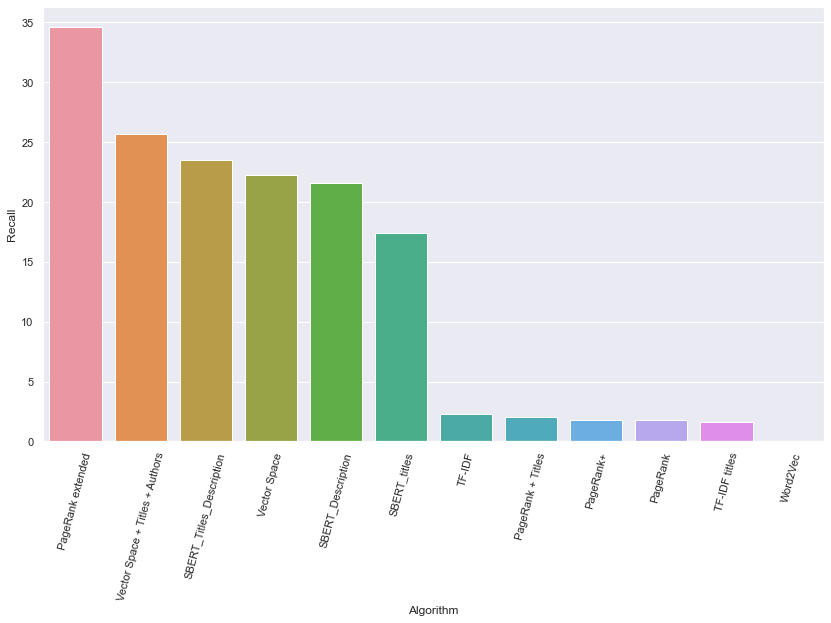

In [1699]:
sns.set(rc={'figure.figsize':(14,8)})
g = sns.barplot(data = df
          ,x = 'Algorithm'
          ,y = 'Recall'
          ,ci = None
          )  
g.set_xticklabels(g.get_xticklabels(),rotation=75)

# Conclusion et fonctions finales 

- Nous avons obtenus nos meilleurs résultats avec PageRank étendu (34% de rappel). 
- Des méthodes comme une moyenne de plusieurs approche a réussi à obtenir un rappel de 25%.
- SBERT a permis de représenté relativement bien le format texte (plus de 20 % de rappel)

## Notre fonction finale de recommandation 

In [1701]:
def fn_recommendations_page_rank_extended(matrice_adjacence_entrainement, *args, **kwargs) : 
    ''' Return recommendations with PageRank extended '''
    
    new_m = matrice_adjacence_entrainement.copy()
    
    m_ = new_m.values @ new_m.values + new_m.values.T + (new_m.values.T @ new_m.values.T) 
    
    new_m = matrice_adjacence_entrainement.copy()
    
    new_m[:] = m_
    
    new_m[new_m>1] = 1 
    
    np.fill_diagonal(new_m.values,0)
    
    r = page_rank(new_m, d= 0.85, epsilon = 1e-5, max_iter = 1000)
    
    recommendations = get_recommendation_page_rank(index = None,r = r, m = new_m, N =20)

    m_rec = convert_recommendation_matrix(recommendations)
    return m_rec
    